In [138]:
import pandas as pd
import numpy as np
import os
import sys
import gc
from sklearn.manifold import TSNE
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
import scipy 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import utils
reload(utils)

<module 'utils' from '/Users/milk/Desktop/git_repositories/READMISSIONS/washtenaw_case_study/notebooks/utils.py'>

In [18]:
matplotlib.rcParams['figure.dpi'] = 200
plt.style.use('seaborn-deep')

In [19]:
"""
Load all Washtenaw Country Images and features
"""

DATA_PATH = "../cleaned_data/clean_data.csv"
data_df = pd.read_csv(DATA_PATH)
data_df['TRACT'] = data_df['TRACT'].astype(str)
print(data_df.shape)

(5013, 5338)


In [20]:
"""
Load column names
"""
tmp = pd.read_csv("../cleaned_data/population_column_map.csv")
POP_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

tmp = pd.read_csv("../cleaned_data/income_column_map.csv")
INC_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

tmp = pd.read_csv("../cleaned_data/occuptation_column_map.csv")
OCC_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

tmp = pd.read_csv("../cleaned_data/education_column_map.csv")
EDU_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

tmp = pd.read_csv("../cleaned_data/income_column_map.csv")
INC_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

tmp = pd.read_csv("../cleaned_data/eigenvalue_column_map.csv")
REDS = tmp['Red_Columns'].to_list()
GREENS = tmp['Green_Columns'].to_list()
BLUES = tmp['Blue_Columns'].to_list()

tmp = pd.read_csv("../cleaned_data/google_column_map.csv")
GOOGLE_RED_COLS = [x for x in tmp['r_color_pixel_columns'] if str(x) != 'nan']
GOOGLE_GREEN_COLS = [x for x in tmp['g_color_pixel_columns'] if str(x) != 'nan']
GOOGLE_BLUE_COLS = [x for x in tmp['b_color_pixel_columns'] if str(x) != 'nan']
GOOGLE_COL_SCORE_COLS = [x for x in tmp['color_score_columns'] if str(x) != 'nan']
GOOGLE_COL_FRAC_COLS = [x for x in tmp['color_fraction_columns'] if str(x) != 'nan']
GOOGLE_LABEL_COLS = [x for x in tmp['Label_columns'] if str(x) != 'nan']
GOOGLE_LABEL_SCORE_COLS = [x for x in tmp['Label_score_columns'] if str(x) != 'nan']

MANUAL_LABELS = [x.strip() for x in open("../image_data/manual_labels.txt")]
print(f"Number of Distinct Labels in curated list: {len(MANUAL_LABELS)}")

Number of Distinct Labels in curated list: 99


In [21]:
"""
Load Land Use
"""

LAND_COVER_PATH = "../demographic_data/washtenaw_landcover.csv"
land_df = pd.read_csv(LAND_COVER_PATH)
print(land_df.shape)

land_df['GEOID'] = land_df['Census Tract 2010 FIPS Code'].astype(int)
LAND_COLS = [x for x in land_df.columns if '(sqm)' in x]
land_df.head()

(100, 37)


,Census Tract 2010 FIPS Code,"NLCD year, interpolated","Flag for interpolated value. 0=Original data, 1=Interpolated data",Interpolated: Unclassified (sqm),Interpolated: Unclassified (sqm): Prop. of measured Census tract area,Interpolated: Open Water (sqm),Interpolated: Open Water (sqm): Prop. of measured Census tract area,Interpolated: Perennial Snow/Ice (sqm),Interpolated: Perennial Snow/Ice (sqm): Prop. of measured Census tract area,"Interpolated: Developed, Open Space (urban imperviousness < 20%) (sqm)",...,Interpolated: Herbaceuous (sqm): Prop. of measured Census tract area,Interpolated: Hay/Pasture (sqm),Interpolated: Hay/Pasture (sqm): Prop. of measured Census tract area,Interpolated: Cultivated Crops (sqm),Interpolated: Cultivated Crops (sqm): Prop. of measured Census tract area,Interpolated: Woody Wetlands (sqm),Interpolated: Woody Wetlands (sqm): Prop. of measured Census tract area,Interpolated: Emergent Herbaceuous Wetlands (sqm),Interpolated: Emergent Herbaceuous Wetlands (sqm): Prop. of measured Census trac,GEOID
0,26161400100,2015,1,0,0,0,0.000000,0,0,0,...,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,26161400100
1,26161400200,2015,1,0,0,38100,0.024785,0,0,194700,...,0.0,0,0.000000,11700,0.007611,34500,0.022443,5100,0.003318,26161400200
2,26161400300,2015,1,0,0,0,0.000000,0,0,171600,...,0.0,7200,0.007360,0,0.000000,0,0.000000,0,0.000000,26161400300
3,26161400400,2015,1,0,0,0,0.000000,0,0,327600,...,0.0,0,0.000000,900,0.000880,0,0.000000,0,0.000000,26161400400
4,26161400500,2015,1,0,0,0,0.000000,0,0,45900,...,0.0,900,0.000918,14400,0.014692,0,0.000000,0,0.000000,26161400500


In [22]:
"""
merge on FIPS code
"""
data_df = pd.merge(data_df, land_df, on='GEOID', how='left')
print(data_df.shape)

(5013, 5375)


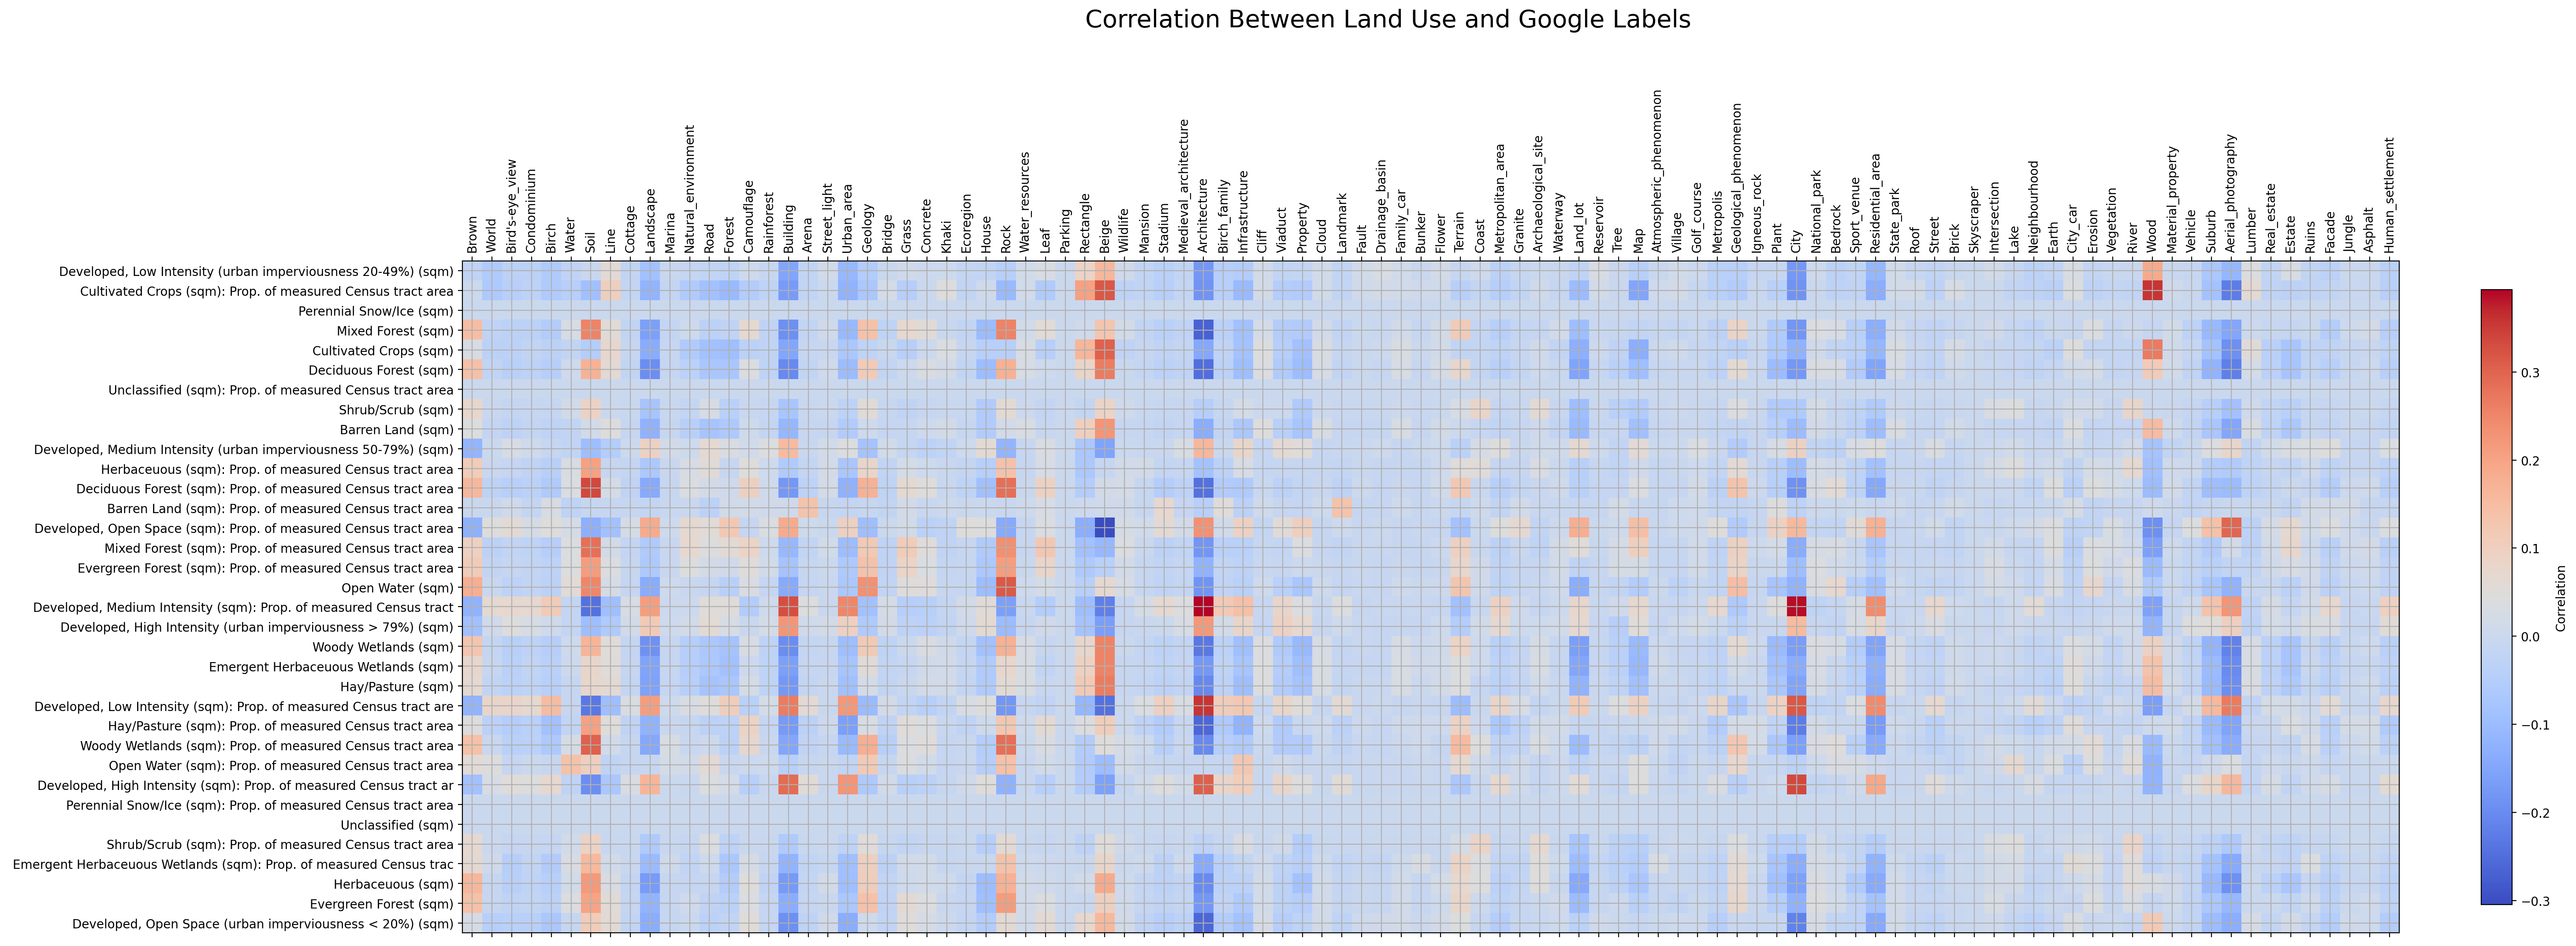

In [81]:
"""
correlations between labels and landuse
"""
TITLE = "Correlation Between Land Use and Google Labels"
FEATURES = list(set(LAND_COLS + MANUAL_LABELS))

# compute correlations
corr = data_df[FEATURES].corr().fillna(0.0)

drop_rows = [x for x in FEATURES if 'label' in x]
drop_cols = [x for x in FEATURES if not 'label' in x]

# drop symmetry for cleaner plot
corr = corr.drop(drop_cols, axis=1)
corr = corr[~corr.index.isin(drop_rows)]

clean_col_names = [x.replace('_label', "") for x in drop_rows]
clean_row_names = [x.replace('Interpolated:', "") for x in drop_cols]

plt.figure(figsize=(30,30))
im = plt.matshow(corr, fignum=1, cmap='coolwarm')
plt.xticks(range(len(clean_col_names)), clean_col_names, rotation=90)
plt.yticks(range(len(clean_row_names)), clean_row_names)
plt.grid()

cb = plt.colorbar(im, fraction=0.015, pad=0.04)
cb.set_label(f'Correlation')
plt.suptitle(TITLE, fontsize=20, y=0.7)

save_filepath = f"../figures/{TITLE}.png"
plt.savefig(save_filepath,  bbox_inches = 'tight')

(134, 134)


Text(0.5, 0.63, 'Correlation Between Land Use and First 100 Blue Channel Eigenvalues')

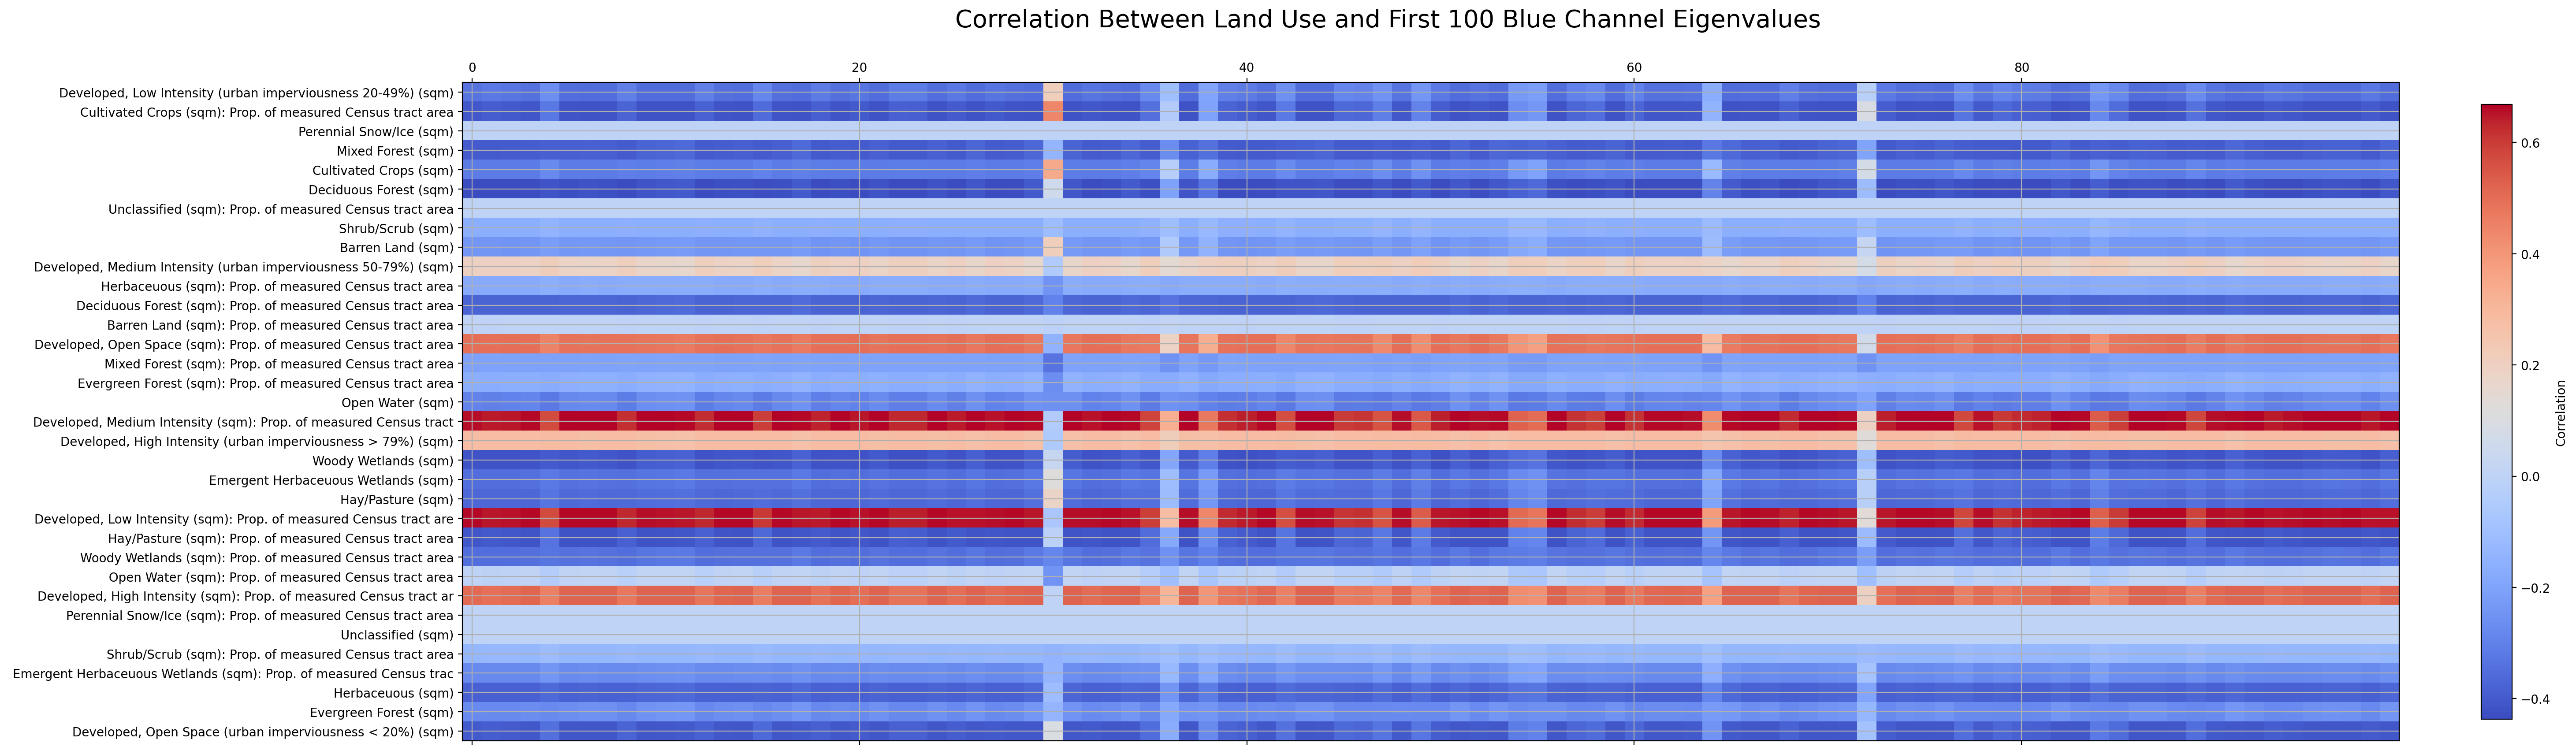

In [103]:
"""
correlations between eigenvalues and landuse
"""

FIRST_N = 100
CHANNEL = 'Blue'
TITLE = f"Correlation Between Land Use and First {FIRST_N} {CHANNEL} Channel Eigenvalues"

chan_dict = {
    'Blue': BLUES,
    'Red': REDS,
    'Green': GREENS
}

FEATURES = list(set(LAND_COLS + chan_dict[CHANNEL][:FIRST_N]))

# compute correlations
corr = data_df[FEATURES].corr().fillna(0.0)
print(corr.shape)

drop_rows = [x for x in FEATURES if 'eig' in x]
drop_cols = [x for x in FEATURES if not 'eig' in x]

# drop symmetry for cleaner plot
corr = corr.drop(drop_cols, axis=1)
corr = corr[~corr.index.isin(drop_rows)]

# clean_col_names = [x.replace('_label', "") for x in drop_rows]
clean_row_names = [x.replace('Interpolated:', "") for x in drop_cols]

plt.figure(figsize=(30,30))
im = plt.matshow(corr, fignum=1, cmap='coolwarm')
# plt.xticks(range(len(clean_col_names)), clean_col_names, rotation=90)
plt.yticks(range(len(clean_row_names)), clean_row_names)
plt.grid()

cb = plt.colorbar(im, fraction=0.015, pad=0.04)
cb.set_label(f'Correlation')
plt.suptitle(TITLE, fontsize=20, y=0.63)

# save_filepath = f"../figures/{TITLE}.png"
# plt.savefig(save_filepath,  bbox_inches = 'tight')

In [116]:
"""
What is the land cover of our images (by tract?) We take the land cover cat with the greatest sq mile
area.
"""
RAW_AREA = [x for x in LAND_COLS if not "Prop" in x]
CLEAN_NAMES  = [x.replace("Interpolated: ", "") for x in RAW_AREA]
trans = dict(zip(range(len(RAW_AREA)), CLEAN_NAMES))

data_df['max_tract_area'] = data_df[RAW_AREA].apply(np.argmax, axis=1)
data_df['max_tract_area'] = data_df['max_tract_area'].replace(trans)
data_df['max_tract_area'].value_counts()

Cultivated Crops (sqm)                                             2891
Woody Wetlands (sqm)                                                746
Deciduous Forest (sqm)                                              703
Developed, Open Space (urban imperviousness < 20%) (sqm)            316
Developed, Low Intensity (urban imperviousness 20-49%) (sqm)        270
Developed, Medium Intensity (urban imperviousness 50-79%) (sqm)      37
Open Water (sqm)                                                     33
Developed, High Intensity (urban imperviousness > 79%) (sqm)         17
Name: max_tract_area, dtype: int64

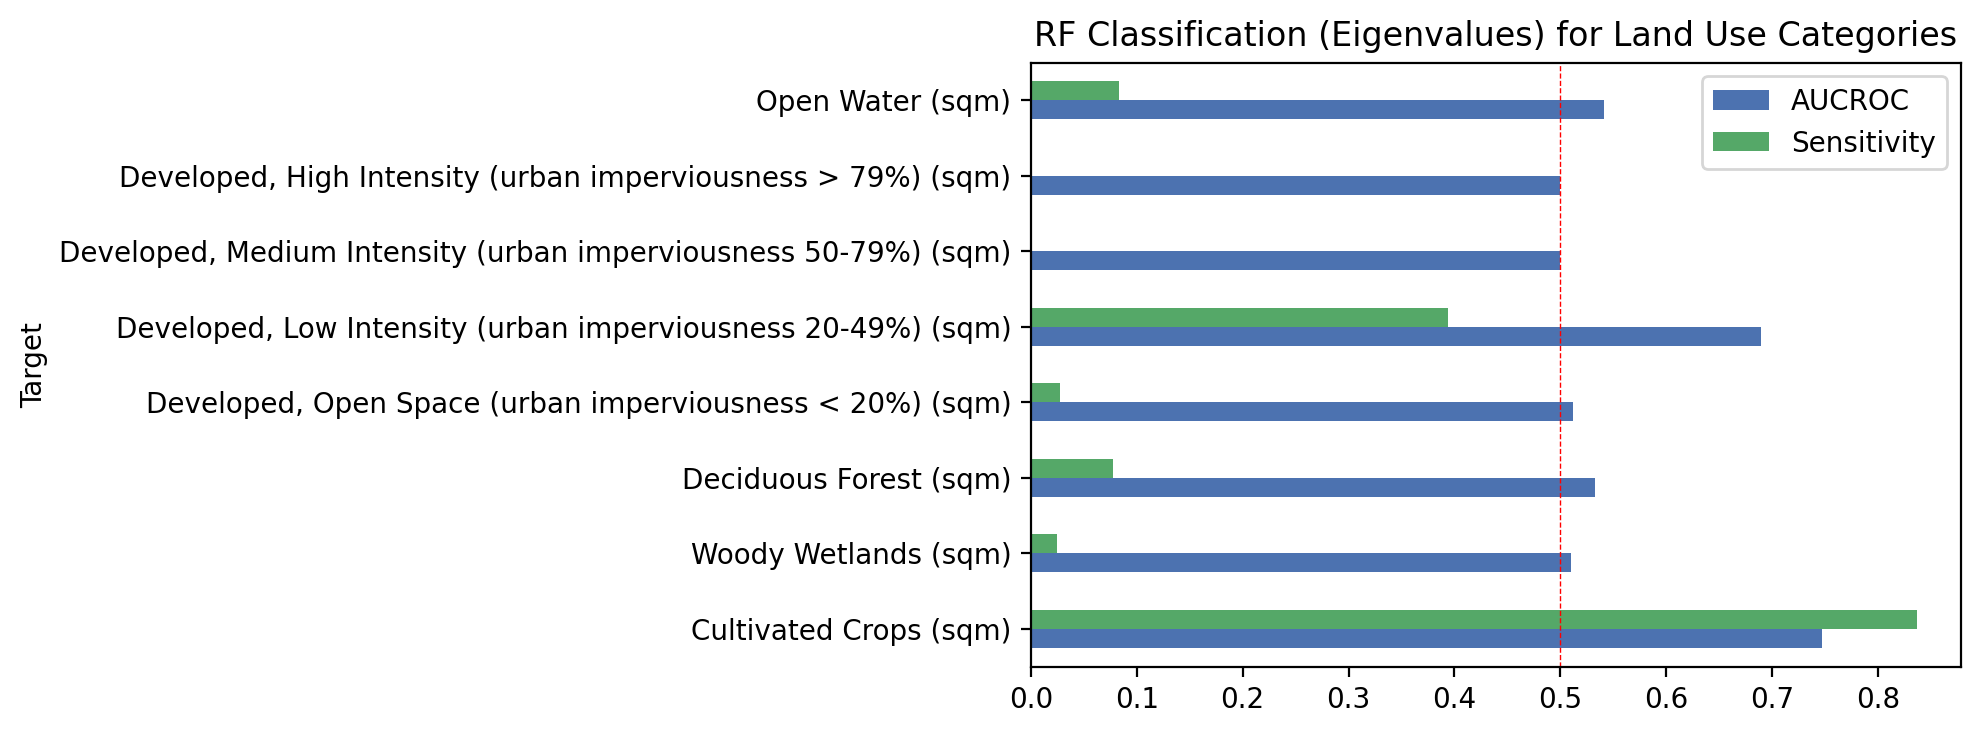

In [152]:
"""
can we predict binary categories using the labels?
"""

TITLE = f"RF Classification (All Features) for Land Use Categories"
FEATURES = REDS + GREENS + BLUES
TARGET_COL = 'max_tract_area'
TARGETS = data_df['max_tract_area'].unique()


new_rows = []

for idx, target in enumerate(TARGETS):

    tmp = data_df.copy()
    tmp = tmp[tmp[TARGET_COL].notnull()]

    targets = np.where(tmp[TARGET_COL] == target, 1, 0)

    tmp[FEATURES] = tmp[FEATURES].replace([np.inf, -np.inf], np.nan).fillna(-99999)
    X_train, X_test, y_train, y_test = train_test_split(tmp[FEATURES],
                                                        targets, 
                                                        test_size=0.33)


    clf = RandomForestClassifier(class_weight = "balanced_subsample")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total = np.sum([tn, fp, fn, tp ])
    auc = roc_auc_score(y_test, y_pred)

    row = {
            'Target':target,
            'AUCROC':auc,
            'True_Positive': tp/total,
            'False_Positive': fp/total,
            'True_Negative': tn/total,
            'False_Negative': fn/total,
            'Sensitivity': tp / (tp + fn),
            'Specificity': tn / (tn + fp)
        }

    new_rows.append(row)

res = pd.DataFrame(new_rows)
res.plot.barh(x='Target', y=['AUCROC', 'Sensitivity'], title=TITLE)
plt.axvline(0.5, color='r', ls='--', lw=0.5)

# save_filepath = f"../figures/{TITLE}.png"
# plt.savefig(save_filepath,  bbox_inches = 'tight')